**CV2021 - week 11**

**Contents**
* [Cross Validation for Architecture Design](https://colab.research.google.com/drive/14Crs9_sV9heHSaqUzSev1pmC1-6ld7Cx#scrollTo=y56nrXmpIbU7&line=3&uniqifier=1)
* [CNN feature extraction](https://colab.research.google.com/drive/14Crs9_sV9heHSaqUzSev1pmC1-6ld7Cx#scrollTo=v1_Js32fe52e&line=7&uniqifier=1)
* [Data Normalization]()
* [CNN Autoencoder]()

**Homework**

* **1bp** Update the cross validation example to accept MLP/CNN models, sending the configurations tested by a *Python dict*, with specific parameters to the model analyzed.
* **1bp** Implement the *K-Fold* cross-validation to evaluate your CNN model over the MNIST dataset. Keep the test data as your benchmark, using just the training data for architecture decisions. Compute the number of parameters, and compare to the result provided by *Keras*.
* **1bp** Using strided convolution, implement a binary classifier for two of the MNIST classes, without using any *Dense* layers.

**1. Architecture design**

In this task, we will propose a cross validation to determine the best configuration for the parameters distribution. The number of epoch used for training will be fixed, and various regularization techniques will be deployed. The observed metric will be the classification accuracy for the validation split.

In [ ]:
import cv2 as cv
import numpy as np
import os
from pyefd import elliptic_fourier_descriptors



def load_dataset(dset_dir):
  # a dict to keep the class of each image
  image_index = {}

  for class_name in os.listdir(dset_dir):
    in_cat_images = []
    cat_dir_path = "{}/{}".format(dset_dir, class_name)
    for file_name in os.listdir(cat_dir_path):
      img_path = "{}/{}".format(cat_dir_path, file_name)
      img = cv.imread(img_path, 0) # open as grayscale
      if img is not None: # unless some corrupted images
        in_cat_images.append(img)
    image_index[class_name] = in_cat_images
  
  return image_index


def extract_efd_feature(img):
  contours, _ = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  fd = []
  for cnt in contours:
    coeffs = elliptic_fourier_descriptors(np.squeeze(cnt), order=10, normalize=True)
    fd.append(coeffs.flatten()[3:])
  return np.array(fd)


def prepare_data(image_set):
  X = []
  Y = []
  for img_class, img_list in image_set.items():
    for image in img_list:
      try:
        fdesc = extract_efd_feature(image)
        X.append(np.max(fdesc, axis=0)) 
        Y.append(int(img_class))
      except np.AxisError:
        continue # some corrupted images

  return np.array(X), np.array(Y)

In [ ]:
train_img = load_dataset("/content/drive/MyDrive/CVCourse21/mnist_png_demo/training/")
val_img = load_dataset("/content/drive/MyDrive/CVCourse21/mnist_png_demo/validation/")
test_img = load_dataset("/content/drive/MyDrive/CVCourse21/mnist_png_demo/testing/")

X_train, Y_train = prepare_data(train_img)
X_val, Y_val = prepare_data(val_img)
X_test, Y_test = prepare_data(test_img)

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, confusion_matrix


layers = [[64, 32, 16], [48, 32, 16], [32, 16]]
reg = [
       regularizers.l1_l2(l1=1e-5, l2=1e-4), 
       regularizers.l2(1e-4),
       regularizers.l2(1e-3),
       regularizers.l1(1e-2)
       ]

best_model = None
best_acc = 0

for layer_conf in layers:
  for regularizer in reg:
    model = Sequential()
    # now, let's add a sequence of Dense layers, based on ReLU activation
    for sz in layer_conf:
      model.add(Dense(sz, activation='relu', kernel_regularizer=regularizer))

    model.add(Dense(10)) # the definition of the classifier stage will be the same
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


    # fit the model keeping 20% of the training data for validation
    model.fit(X_train, Y_train, epochs=15, validation_data=(X_val, Y_val), verbose=0)
    predictions = model.predict_classes(X_val, verbose=1)

    print("Classification accuracy for configuration {} with regularizer {}: {}".format(
        layer_conf, regularizer, accuracy_score(Y_val, predictions)))
    if accuracy_score(Y_val, predictions) > best_acc:
      best_model = model
      best_acc = accuracy_score(Y_val, predictions)

InvalidArgumentError: assertion failed: [0] [Op:Assert] name: EagerVariableNameReuse

In [ ]:
def plot_evaluation_report(X_test, model):
  predictions = model.predict_classes(X_test, verbose=1)
  print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))
  clf_confusion_matrix = confusion_matrix(Y_test, predictions)
  classes = [str(i) for i in range(10)]

  df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
  df_cmatrix.style.format("{:.1f}")

  sn.set(font_scale=1.4) 
  sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16}, fmt='g')


# evaluate the best model
plot_evauation_report(X_test, best_model)

**2. Convolutional Neural Nets for feature extraction**

In this task, we will create our first CNN classifier. To compare it to the MLP classifier built last week, we will keep the same configuration, but the image will not be flattened as input. A sequence of Convolutional Layers will be used to extract features, and techniques for dimensionality reduction will be deployed.

**References**
* [Keras Conv Layer](https://keras.io/api/layers/convolution_layers/convolution2d/)
* [Keras CNN classifier](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [2]:
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

In [ ]:
from keras.callbacks import Callback


class TestCallback(Callback):
  def __init__(self, train_data, test_data, verbose=False):
    self.train_data = train_data
    self.test_data = test_data

    self.train_log = {}
    self.test_log = {}
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    x_train, y_train = self.train_data
    x_test, y_test = self.test_data

    train_loss, train_acc = self.model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)

    self.train_log[epoch] = train_acc
    self.test_log[epoch] = test_acc

    if self.verbose == True:
      log = 'E: {} - Train - Test loss: {} - {}, acc: {} - {}'.format(
              epoch, train_loss, test_loss, train_acc, test_acc)
      print(log)

In [3]:
# firslty, we will load the MNIST dataset
def get_mnist_data():
  (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
  X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
  X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
  Y_train = to_categorical(Y_train) # use one-hot encoding
  Y_test = to_categorical(Y_test)
  # we will experiment with data normalization later
  return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = get_mnist_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax')) # note the introduction of a softmax output layer, dropping from_logits=True
	# compile model
	model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
baseline_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]
model.fit(X_train, Y_train, epochs=50, callbacks=baseline_callbacks, validation_split=0.2)

Epoch 1/50
1500/1500 [==============================] - 9s 6ms/step - loss: 19.2193 - accuracy: 0.5137 - val_loss: 1.0404 - val_accuracy: 0.7408
Epoch 2/50
1500/1500 [==============================] - 8s 5ms/step - loss: 1.0893 - accuracy: 0.6856 - val_loss: 0.8063 - val_accuracy: 0.7450
Epoch 3/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.8699 - accuracy: 0.7337 - val_loss: 0.6674 - val_accuracy: 0.8306
Epoch 4/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.5902 - accuracy: 0.8296 - val_loss: 0.4796 - val_accuracy: 0.8920
Epoch 5/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3889 - accuracy: 0.8993 - val_loss: 0.2808 - val_accuracy: 0.9348
Epoch 6/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2445 - accuracy: 0.9426 - val_loss: 0.2559 - val_accuracy: 0.9499
Epoch 7/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1803 - accuracy: 0.9561 - val_loss: 0.2241 - val_accuracy

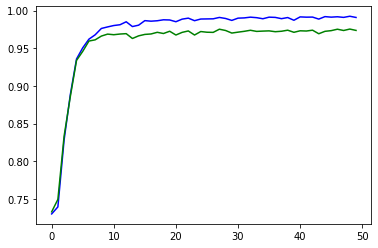

In [ ]:
cb = baseline_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Train acc.', c='blue')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label=' Test acc.', c='green')

In [ ]:
# now we will add complexity in the feature extraction stage, by stacking multiple layers
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax')) # note the introduction of a softmax output layer, dropping from_logits=True
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
feature_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]
model.fit(X_train, Y_train, epochs=50, callbacks=feature_callbacks, validation_split=0.2)

Epoch 1/50
1500/1500 [==============================] - 9s 5ms/step - loss: 16.9338 - accuracy: 0.5929 - val_loss: 0.5607 - val_accuracy: 0.8492
Epoch 2/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5251 - accuracy: 0.8511 - val_loss: 0.3638 - val_accuracy: 0.8975
Epoch 3/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3492 - accuracy: 0.8974 - val_loss: 0.2978 - val_accuracy: 0.9127
Epoch 4/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2535 - accuracy: 0.9252 - val_loss: 0.2444 - val_accuracy: 0.9316
Epoch 5/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2071 - accuracy: 0.9389 - val_loss: 0.2025 - val_accuracy: 0.9410
Epoch 6/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1766 - accuracy: 0.9477 - val_loss: 0.1599 - val_accuracy: 0.9541
Epoch 7/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1501 - accuracy: 0.9541 - val_loss: 0.1662 - val_accuracy

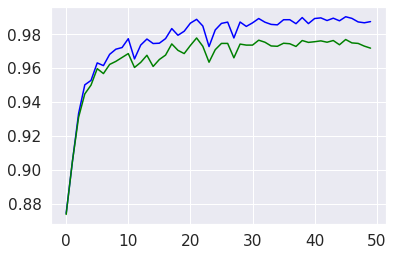

In [ ]:
cb = feature_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Train acc.', c='blue')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label='Test acc', c='green')

In [ ]:
# Now, we will add complexity in the classifier stage
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax')) # note the introduction of a softmax output layer, dropping from_logits=True
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

 
clf_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]
model.fit(X_train, Y_train, epochs=50, callbacks=clf_callbacks, validation_split=0.2)


Epoch 1/50
1500/1500 [==============================] - 37s 6ms/step - loss: 15.2876 - accuracy: 0.7950 - val_loss: 0.6365 - val_accuracy: 0.9347
Epoch 2/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4716 - accuracy: 0.9393 - val_loss: 0.2814 - val_accuracy: 0.9542
Epoch 3/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1985 - accuracy: 0.9601 - val_loss: 0.1955 - val_accuracy: 0.9626
Epoch 4/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1313 - accuracy: 0.9671 - val_loss: 0.1312 - val_accuracy: 0.9711
Epoch 5/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0904 - accuracy: 0.9764 - val_loss: 0.1349 - val_accuracy: 0.9731
Epoch 6/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0732 - accuracy: 0.9787 - val_loss: 0.1599 - val_accuracy: 0.9631
Epoch 7/50
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0651 - accuracy: 0.9809 - val_loss: 0.1255 - val_accurac

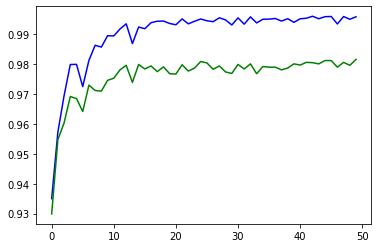

In [ ]:
cb = clf_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Train acc.', c='blue')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label='Test acc', c='green')

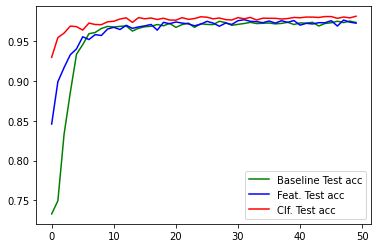

In [ ]:
plt.plot(list(baseline_callbacks[0].test_log.keys()), list(baseline_callbacks[0].test_log.values()), label='Baseline Test acc', c='g')
plt.plot(list(feature_callbacks[0].test_log.keys()), list(feature_callbacks[0].test_log.values()), label='Feat. Test acc', c='b')
plt.plot(list(clf_callbacks[0].test_log.keys()), list(clf_callbacks[0].test_log.values()), label='Clf. Test acc', c='r')
plt.legend()

**3. Data Normalization**

We will  experimant with the normalization layers offered by *keras*, and see their effect in the classification performance. 

The options offered are *Batch Normalization*, where the data is normalized by the batch axis, to fit in the [-1, 1] interval. 

For the *Layer Normalization*, the activations coming from the previous layer are normalized, for each given instance in the batch.

**References**
* [Keras doc](https://keras.io/api/layers/normalization_layers/)

In [ ]:
from keras.layers import BatchNormalization
from keras.layers import LayerNormalization
#from keras.layers import GroupN

In [ ]:
# now we will add complexity in both stages, by stacking multiple layers
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax')) # note the introduction of a softmax output layer, dropping from_logits=True
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_norm_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]
model.fit(X_train, Y_train, epochs=50, callbacks=batch_norm_callbacks, validation_split=0.2)

Epoch 1/50
1500/1500 [==============================] - 11s 6ms/step - loss: 0.6307 - accuracy: 0.7988 - val_loss: 0.1223 - val_accuracy: 0.9606
Epoch 2/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1162 - accuracy: 0.9644 - val_loss: 0.0857 - val_accuracy: 0.9737
Epoch 3/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0840 - accuracy: 0.9747 - val_loss: 0.0786 - val_accuracy: 0.9758
Epoch 4/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0672 - accuracy: 0.9789 - val_loss: 0.0689 - val_accuracy: 0.9784
Epoch 5/50
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0571 - accuracy: 0.9816 - val_loss: 0.0721 - val_accuracy: 0.9778
Epoch 6/50
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0514 - accuracy: 0.9839 - val_loss: 0.1097 - val_accuracy: 0.9708
Epoch 7/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0461 - accuracy: 0.9851 - val_loss: 0.0636 - val_accuracy

In [ ]:
# now we will add complexity in the feature extraction stage, by stacking multiple layers
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(LayerNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(LayerNormalization())
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(LayerNormalization())
model.add(Dense(10, activation='softmax')) # note the introduction of a softmax output layer, dropping from_logits=True
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
layer_norm_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]
model.fit(X_train, Y_train, epochs=50, callbacks=layer_norm_callbacks, validation_split=0.2)

Epoch 1/50
1500/1500 [==============================] - 11s 6ms/step - loss: 0.6613 - accuracy: 0.7974 - val_loss: 0.1451 - val_accuracy: 0.9565
Epoch 2/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1231 - accuracy: 0.9625 - val_loss: 0.0981 - val_accuracy: 0.9703
Epoch 3/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0970 - accuracy: 0.9699 - val_loss: 0.0906 - val_accuracy: 0.9727
Epoch 4/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0747 - accuracy: 0.9779 - val_loss: 0.0847 - val_accuracy: 0.9764
Epoch 5/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0662 - accuracy: 0.9796 - val_loss: 0.0737 - val_accuracy: 0.9787
Epoch 6/50
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0615 - accuracy: 0.9812 - val_loss: 0.0802 - val_accuracy: 0.9774
Epoch 7/50
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0498 - accuracy: 0.9839 - val_loss: 0.0683 - val_accuracy

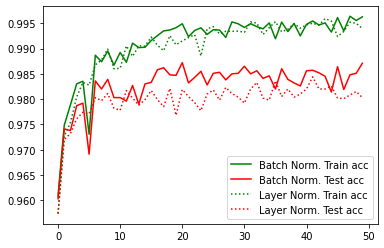

In [ ]:
plt.plot(list(batch_norm_callbacks[0].train_log.keys()), list(batch_norm_callbacks[0].train_log.values()), 'g-', label='Batch Norm. Train acc')
plt.plot(list(batch_norm_callbacks[0].test_log.keys()), list(batch_norm_callbacks[0].test_log.values()), 'r-', label='Batch Norm. Test acc')

plt.plot(list(layer_norm_callbacks[0].train_log.keys()), list(layer_norm_callbacks[0].train_log.values()), 'g:', label='Layer Norm. Train acc')
plt.plot(list(layer_norm_callbacks[0].test_log.keys()), list(layer_norm_callbacks[0].test_log.values()), 'r:', label='Layer Norm. Test acc')
plt.legend()

**4. CNN Autoencoder for image compression**
Similarly to the last task of *week 10* session, we will build an Autoencoder network, to learn a representation of the image in a learnt latent space. 
The quality of the earn representation will be assessed by a SVC classifier, keeping the same parameters as in the examples discussed int he previous weeks.

**References**
* [Autoencoders in Keras]()

In [ ]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [ ]:
from keras import Input, Model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Flatten


input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # use pooling to reduce by half the width/height of the representation

# x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x) 

latent = Flatten()(encoded)

# x = Conv2D(48, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x) # use upsampling as the inverse of pooling

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# compile the models for encoder and autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

encoder = Model(input_img, latent)

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
469/469 [==============================] - 12s 13ms/step - loss: 0.2029 - val_loss: 0.0775
Epoch 2/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0766 - val_loss: 0.0728
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0729 - val_loss: 0.0707
Epoch 4/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0711 - val_loss: 0.0697
Epoch 5/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0700 - val_loss: 0.0687
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0692 - val_loss: 0.0681
Epoch 7/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0685 - val_loss: 0.0676
Epoch 8/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0680 - val_loss: 0.0672
Epoch 9/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0675 - val_loss: 0.0669
Epoch 10/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0673 - val_l

In [ ]:
X_enc_train = encoder.predict(X_train)
print(X_enc_train.shape)
X_enc_test = encoder.predict(X_test)

(60000, 1568)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


(_, Y_train), (_, Y_test) = mnist.load_data()

scaler = StandardScaler()
X_enc_train = scaler.fit_transform(X_enc_train)
X_enc_test = scaler.transform(X_enc_test)

clf =  SVC(C=1.5, kernel='rbf', gamma='auto')
clf.fit(X_enc_train, Y_train)
predictions = clf.predict(X_enc_test)


In [ ]:
print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))

Classification accuracy: 0.9797


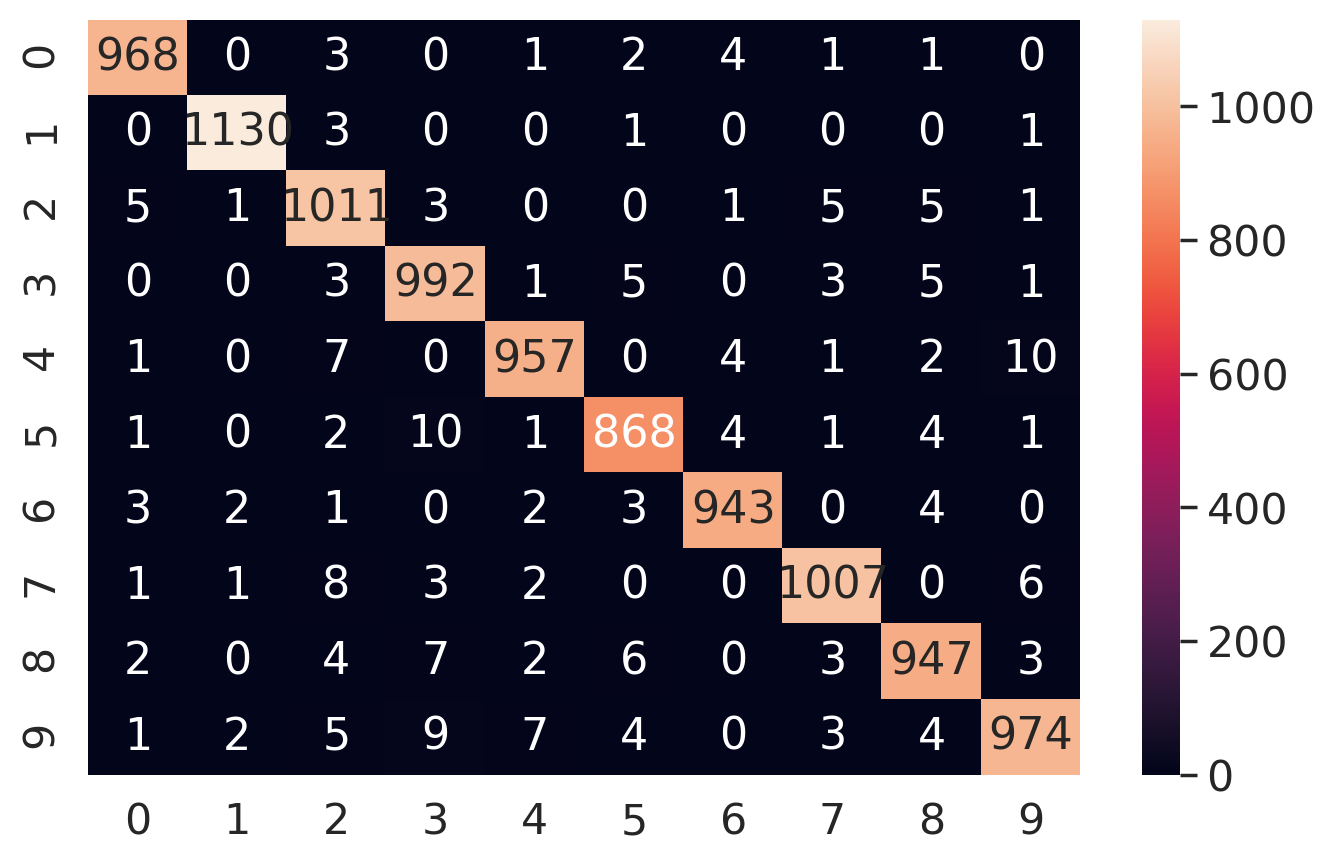

In [ ]:
clf_confusion_matrix = confusion_matrix(Y_test, predictions)
classes = [str(i) for i in range(10)]

df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
df_cmatrix.style.format("{:.1f}")


sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16}, fmt='g')

In [5]:
# now, let's see if a larger receptive field leads to a better representation
X_train, Y_train, X_test, Y_test = get_mnist_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [6]:
from keras import Input, Model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Flatten


input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # use pooling to reduce by half the width/height of the representation

# x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x) 

latent = Flatten()(encoded)

# x = Conv2D(48, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x) # use upsampling as the inverse of pooling

x = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# compile the models for encoder and autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

encoder = Model(input_img, latent)

autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
469/469 [==============================] - 43s 8ms/step - loss: 0.2002 - val_loss: 0.0789
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0783 - val_loss: 0.0741
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0739 - val_loss: 0.0717
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0719 - val_loss: 0.0704
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0705 - val_loss: 0.0691
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0697 - val_loss: 0.0685
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0691 - val_loss: 0.0682
Epoch 8/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0684 - val_loss: 0.0675
Epoch 9/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0680 - val_loss: 0.0671
Epoch 10/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0676 - val_loss: 0.066

In [7]:
X_enc_train = encoder.predict(X_train)
X_enc_test = encoder.predict(X_test)

Classification accuracy: 0.9838


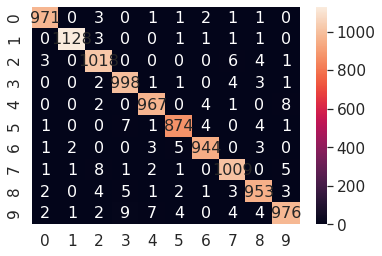

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

(_, Y_train), (_, Y_test) = mnist.load_data()
scaler = StandardScaler()
X_enc_train = scaler.fit_transform(X_enc_train)
X_enc_test = scaler.transform(X_enc_test)

clf =  SVC(C=1.5, kernel='rbf', gamma='auto')
clf.fit(X_enc_train, Y_train)
predictions = clf.predict(X_enc_test)
print("Classification accuracy: {}".format(accuracy_score(Y_test, predictions)))


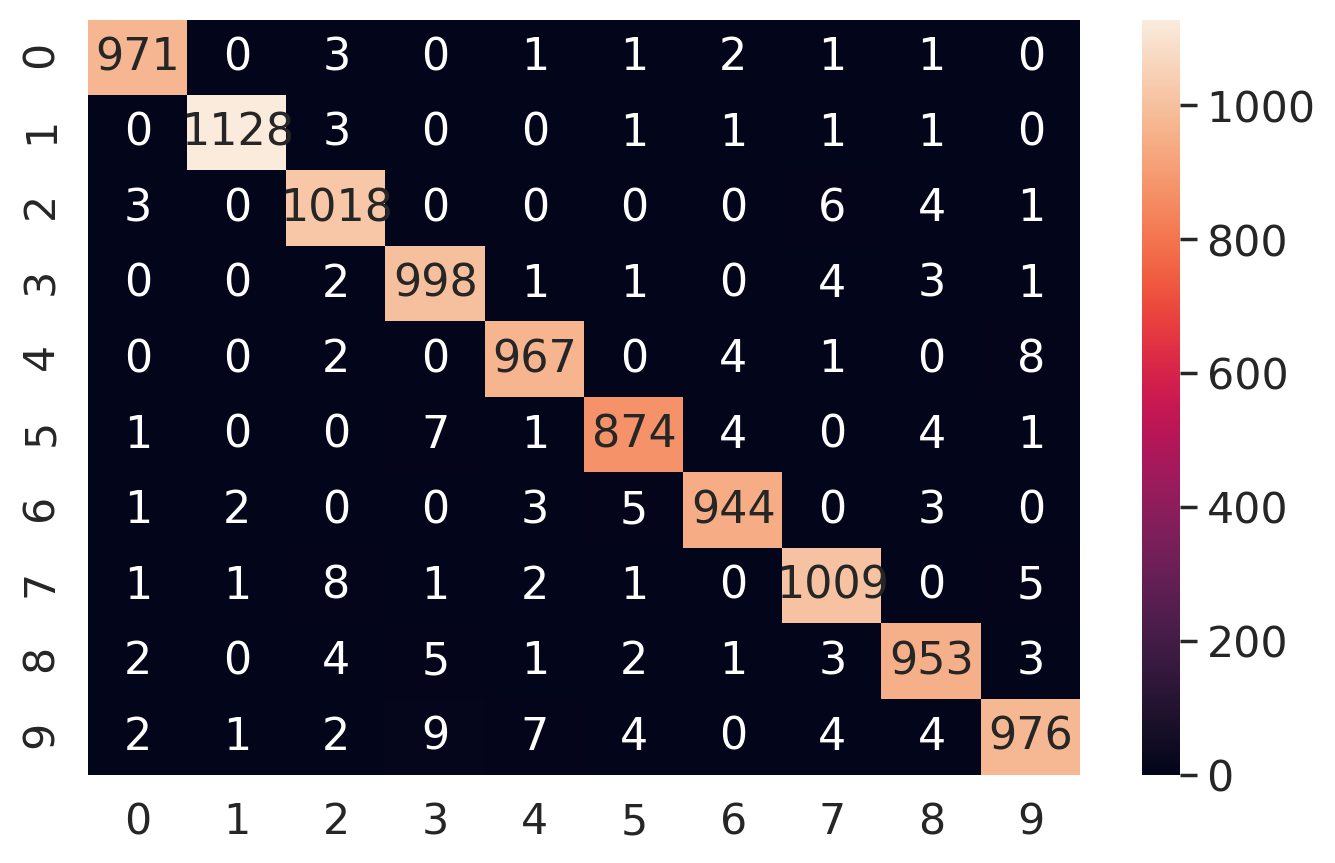

In [12]:
clf_confusion_matrix = confusion_matrix(Y_test, predictions)
classes = [str(i) for i in range(10)]

df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
df_cmatrix.style.format("{:.1f}")


sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16}, fmt='g')